In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# (1) - Importing dataset

In [2]:
df = pd.read_excel(r"C:\Users\Acer\DataSets\Stock_Products.xlsx")

In [3]:
df

,SKU,Warehouse,Lead_Time,Qty_Sold
0,0,Warehouse A,9,195
1,1,Warehouse B,11,172
2,2,Warehouse C,13,497
3,3,Warehouse C,6,316
4,4,Warehouse A,11,219
...,...,...,...,...
1014,1014,Warehouse A,13,15
1015,1015,Warehouse A,12,16
1016,1016,Warehouse A,10,13
1017,1017,Warehouse A,14,19


# (2) - Separating Qty and Lead_Time DataFrames

In [4]:
df_qty = df[['SKU', 'Qty_Sold']].copy()
df_lead = df[['SKU', 'Lead_Time']].copy()

In [5]:
df_qty

,SKU,Qty_Sold
0,0,195
1,1,172
2,2,497
3,3,316
4,4,219
...,...,...
1014,1014,15
1015,1015,16
1016,1016,13
1017,1017,19


In [6]:
df_lead

,SKU,Lead_Time
0,0,9
1,1,11
2,2,13
3,3,6
4,4,11
...,...,...
1014,1014,13
1015,1015,12
1016,1016,10
1017,1017,14


# (3) - Creating ABC Segmentation Curve for SKU's Qty

In [7]:
df_qty

,SKU,Qty_Sold
0,0,195
1,1,172
2,2,497
3,3,316
4,4,219
...,...,...
1014,1014,15
1015,1015,16
1016,1016,13
1017,1017,19


In [8]:
df_qty['Total_Qty'] = df_qty['Qty_Sold'].sum() # Creating total quantity column
df_qty = df_qty.sort_values(by='Qty_Sold', ascending=False) # Ordering descending by Qty_Sold
df_qty['Percentage'] = df_qty['Qty_Sold']/df_qty['Total_Qty'] # Getting the representativeness of each product in sales
df_qty['Cum_Perc'] = df_qty['Percentage'].cumsum() # Getting the cummulative percentage to use in ABC Segmentation
# Creating ABC Segmentation based on Cummulative Percentage column
df_qty['Category'] = list(map(lambda x: 'A' if x < 0.75 else ('B' if x < 0.95 else 'C'), df_qty['Cum_Perc']))

In [9]:
df_qty['Category'].value_counts() # Taking a view of product types (SKUs) per category

C    409
B    392
A    218
Name: Category, dtype: int64

In [10]:
df_qty['Category'].count() # Taking a view of total product types (SKUs)

1019

# Comments
#### We have 221 products on category A, which means that approximately 80% of total sales volumes are represented by 221/1019 = 21.6% of the total product types. 

#### Also, B and C categories, which counts 386+412= 798 products, represents the other 20% of total sales volumes, which are 798/1019 = 78% of the total product types.

#### We can see the Pareto Principle, which states that 80% of the outcomes (products on stock) comes from 20% of the causes (product types).

# (4) - Plotting ABC Curve

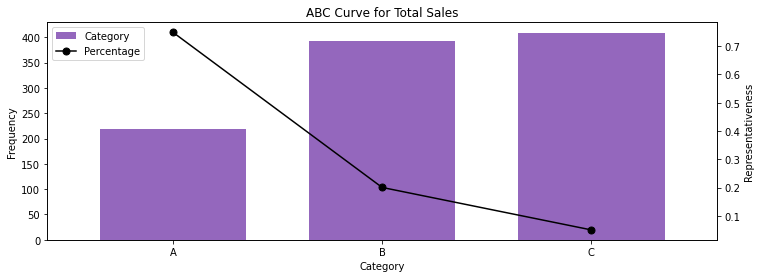

In [11]:
category_counts = df_qty['Category'].value_counts().sort_values()
cumulative_percentages = df_qty.groupby('Category')['Percentage'].sum()


fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()

# Bar graph for category frequency
category_counts.plot(kind='bar', ax=ax1, color='C4', position=0.5, width=0.7)
ax1.set_ylabel('Frequency', color='k')

# Line graph for cumulative sum of Cum_Percentage
cumulative_percentages.plot(kind='line', ax=ax2, color='k', marker='o', ms=7)
ax2.set_ylabel('Representativeness', color='k')

# Set x-axis tick labels
ax1.set_xticklabels(category_counts.index, rotation=0)

# Adding legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Title and labels
plt.title('ABC Curve for Total Sales')
ax1.set_xlabel('Category')

plt.show()

# Comments
#### We can see from the above chart for category A, we have 221 products which represents approximately 80% of total sales volumes (percentage line).

#### Categories B and C have the majority product types (798 product types) and represents approximately 20% of total sales volumes.

# (5) - Boxplot Analysis and Creating Categories for Lead Times

# Creating boxplot to analyze distribution of Lead Times

<Axes: xlabel='Lead_Time'>

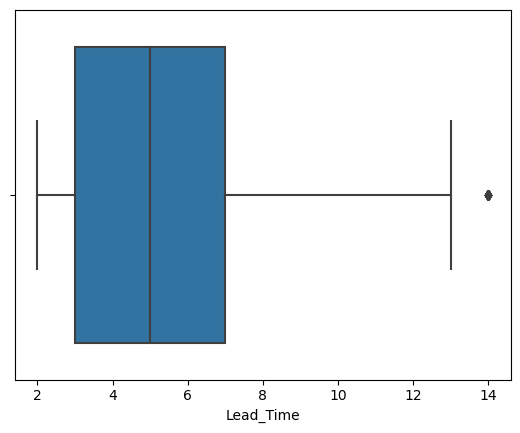

In [20]:
sns.boxplot(data=df_lead, x='Lead_Time')

# Comments
#### From the boxplot it's possible to see that 50% of the lead times values falls between 3 and 7 days (values between 1st and 3rd quartile). 

#### Also, the minimum value is 2 days and maximum is 13. We have some outliers with 14 days. The best practice when dealing with outliers is use the median, so we are going to use the median value = 5 days to split the lead times into the categories. 

#### We are going to use values 0, 5 and 10 to represent low, medium and high lead times.

In [10]:
df_lead['Category'] = list(map(lambda x: '0' if x < 5 else ('5' if x == 5 else '10'), df_lead['Lead_Time']))

In [13]:
df_lead['Category'].value_counts()

0     440
10    423
5     156
Name: Category, dtype: int64

# (6) - Merging the DataFrames to analyze categories together

In [25]:
df_merged = pd.merge(df_lead, df_qty[['SKU', 'Category']], on='SKU')
df_merged = df_merged[['SKU', 'Category_y', 'Category_x']]
df_merged.rename(columns={'Category_x': 'Lead_Times'}, inplace=True)
df_merged.rename(columns={'Category_y': 'ABC'}, inplace=True)
df_merged['Final_Segmented'] = df_merged['ABC']+df_merged['Lead_Times']
df_final = df_merged.groupby('Final_Segmented')['SKU'].count().reset_index()

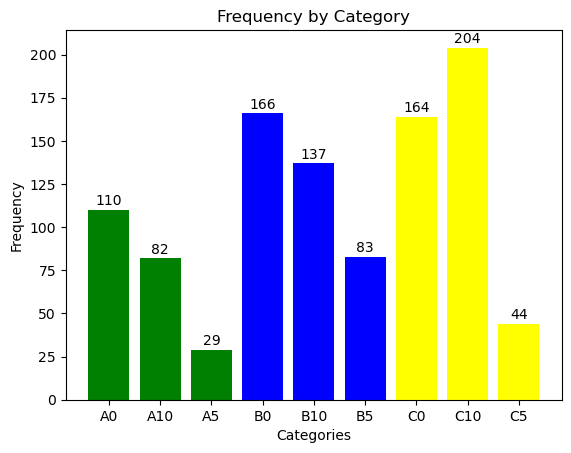

In [90]:
colors = ['green' if cat.startswith('A') else 'blue' if cat.startswith('B') else 'yellow' for cat in df_final['Final_Segmented']]

plt.bar(df_final['Final_Segmented'], df_final['SKU'], color=colors)


for category, value in zip(df_final['Final_Segmented'], df_final['SKU']):
    plt.text(category, value + 1, str(value), ha='center', va='bottom', fontsize=10)
    
# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Frequency by Category')

# Display the plot
plt.show()

# Final Considerations

### A0 → Represents 75% of sales volumes, and contains 22% of total product types. In addition, it has a low lead time

### A5 → Represents 75% of sales volumes, and contains 22% of total product types. In addition, it has an intermediate lead time

### A10 → Represents 75% of sales volumes, and contains 22% of total product types. In addition, it has a high lead time

### B0 → Represents 20% of sales volumes, and contains 38% of total product types. In addition, it has a short lead time

### B5 -> Represents 20% of sales volumes, and contains 38% of total product types. In addition, it has an intermediate lead time

### B10 → Represents 20% of sales volumes, and contains 38% of total product types. In addition, it has a high lead time

### C0 → Represents 5% of sales volumes, and contains 40% of total product types. In addition, it has a low lead time

### C5 → Represents 5% of sales volumes, and contains 40% of total product types. In addition, it has an intermediate lead time

### C10 → Represents 5% of sales volumes, and contains 40% of total product types. In addition, it has a high lead time